In [1]:
%matplotlib inline
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import datetime
from IPython.core.pylabtools import figsize
warnings.filterwarnings('ignore')

### Download data

In [2]:
if not os.path.exists('./data'):
    os.mkdir('./data')

In [3]:
# Get SF crime data
if not os.path.exists('./data/sf_data.csv'):
    !wget -O ./data/sf_data.csv https://data.sfgov.org/api/views/gxxq-x39z/rows.csv?accessType=DOWNLOAD

In [4]:
# Get Raleigh crime data
if not os.path.exists('./data/raleigh_data.csv'):
    !wget -O ./data/raleigh_data.csv https://data.raleighnc.gov/api/views/csw9-dd5k/rows.csv?accessType=DOWNLOAD

In [5]:
df_sf = pd.read_csv('./data/sf_data.csv')
df_ra = pd.read_csv('./data/raleigh_data.csv')

### Identify Categories

In [6]:
sf_cats = df_sf['Category'].unique()
ra_cats = df_ra['LCR DESC'].unique()
sf_gta_cats = ['VEHICLE THEFT']
sf_murder_cats = None
ra_gta_cats = ['Larceny/Theft from Motor Vehicle', 
               'MV THEFT/OTHER VEHICLES', 
               'MV THEFT/AUTOMOBILE', 
               'MV THEFT/TRUCK OR BUS']

ra_murder_cats = ['Homicide/Murder-Nonnegligent Manslaughter', 
                  'MURDER AND NONNEGLIGENT MANSLAUGHTER', 
                  'MURDER/MANSLAUGHTER BY NEGLIGENCE']

In [8]:
def subset_dataframe_inds(df, cats, on):
    if cats:
        inds = (df[on] == x for x in cats)
        X = sum(inds)
        return df[X == 1]
    
def parse_date(x):
    date = x['Date']
    time = x['Time']
    hour, minute = time.split(":")
    dt = datetime.datetime.strptime(date, fmt)
    dt = dt.replace(hour=int(hour), minute=int(minute))
    return dt
    

def create_time_var(df, time_var, fmt):
    return df[time_var].apply(lambda x: datetime.datetime.strptime(x, fmt))

In [9]:
df_ra_gta = subset_dataframe_inds(df_ra, ra_gta_cats, 'LCR DESC')
df_ra_murder = subset_dataframe_inds(df_ra, ra_murder_cats, 'LCR DESC')
df_sf_gta = subset_dataframe_inds(df_sf, sf_gta_cats, 'Category')
df_sf_murder = subset_dataframe_inds(df_sf, sf_murder_cats, 'Category')

### Create Time Series

In [10]:
fmt = '%m/%d/%Y %I:%M:%S %p'
df_ra_gta['time'] = create_time_var(df_ra_gta, 'INC DATETIME', fmt)
df_ra_murder['time'] = create_time_var(df_ra_murder, 'INC DATETIME', fmt)
df_sf_gta['time'] = df_sf_gta.apply(parse_date, axis=1)
#df_sf_murder['time'] = df_sf_murder.apply(parse_date, axis=1)

In [12]:
def create_ts(df, freq):
    N = len(df)
    ones = np.ones(N)
    ts = pd.Series(data=ones, index=df.time)
    tss = ts.resample(freq, how="sum")
    tss = tss.fillna(0)
    return tss

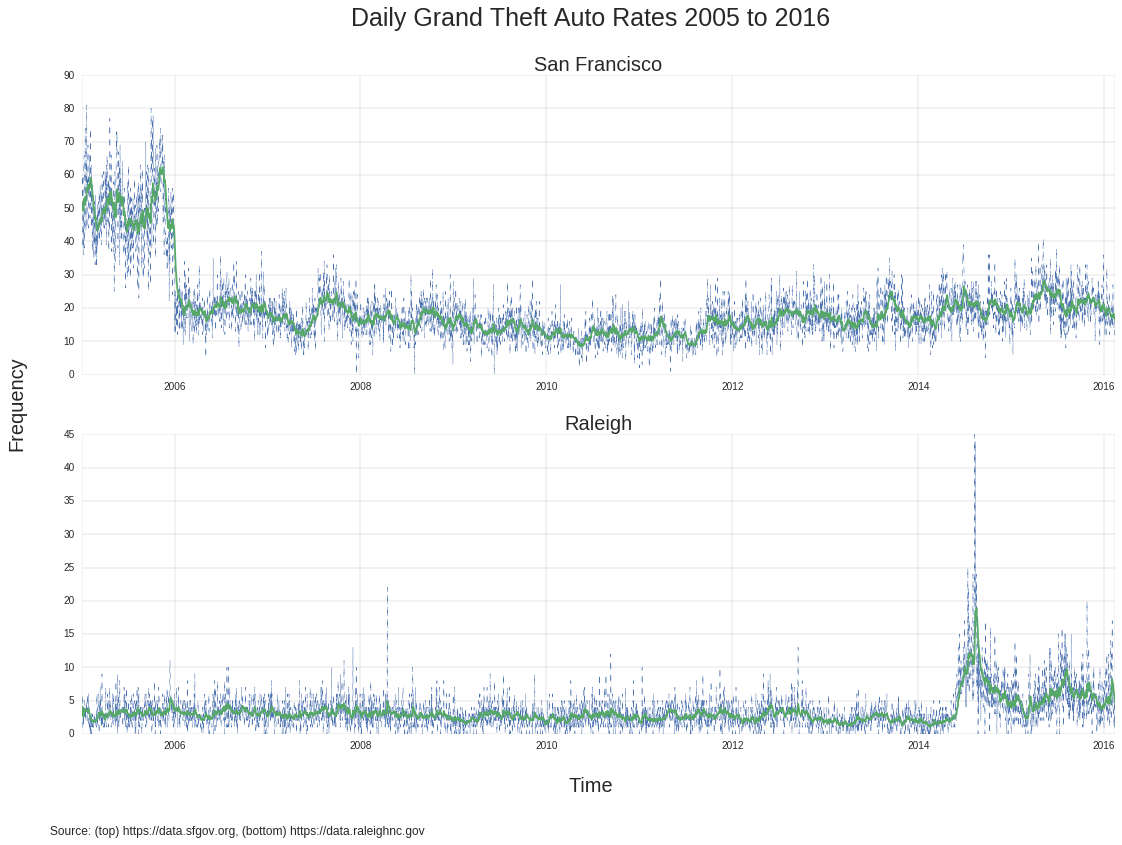

In [13]:
#Merge time series
ts_ra_gta = create_ts(df_ra_gta, "1D")
ts_sf_gta = create_ts(df_sf_gta, "1D")
#Span is size of window
ts_ra_gta_ewma = pd.ewma(ts_ra_gta, span=20)
ts_sf_gta_ewma = pd.ewma(ts_sf_gta, span=20)
df_ra_gta_ts = pd.DataFrame( {'Raleigh': ts_ra_gta, 
                              'Raleigh Smooth': ts_ra_gta_ewma})
df_sf_gta_ts = pd.DataFrame( {'SF': ts_sf_gta,
                              'SF Smooth': ts_sf_gta_ewma})
df_gta_ts = pd.merge(df_ra_gta_ts, df_sf_gta_ts, left_index=True, right_index=True)

min_year = df_gta_ts.index.min().year
max_year = df_gta_ts.index.max().year


#Plot
fig, axes = plt.subplots(nrows=2, ncols=1, #sharex=True, #sharey=True, 
                         figsize=(15, 10))

fig.text(0.5, -0.04, 'Time', ha='center', fontsize=20)
fig.text(-0.04, 0.5, 'Frequency', va='center', rotation='vertical', fontsize=20)


grid_lw = 0.2
ax1 = axes[0]
ax1.set_axis_bgcolor('white')
ax1.grid(which='major', color='grey', lw=grid_lw) 
ax1.grid(which='minor', color='white', lw=grid_lw) 

df_gta_ts['SF'].plot(style='--', lw=0.5, ax=ax1)
df_gta_ts['SF Smooth'].plot(ax=ax1)
ax1.set_xlabel('')
ax1.set_title('San Francisco', fontsize=20)

ax2 = axes[1]
ax2.set_axis_bgcolor('white')
ax2.grid(which='major', color='grey', lw=grid_lw) 
ax2.grid(which='minor', color='white', lw=grid_lw)
df_gta_ts['Raleigh'].plot(style='--', lw=0.5, ax=ax2)
df_gta_ts['Raleigh Smooth'].plot(ax=ax2)
ax2.set_xlabel('')
ax2.set_title('Raleigh', fontsize=20)

suptitle = 'Daily Grand Theft Auto Rates {0} to {1}'.format(min_year, max_year)
plt.suptitle(suptitle, x=0.5, y=1.05, fontsize=25)
plt.tight_layout()
plt.subplots_adjust(hspace = 0.2)

plt.figtext(0, -0.1, '''Source: (top) https://data.sfgov.org, (bottom) https://data.raleighnc.gov''')
#plt.figtext(0, -0.1, '''Source: (top) https://data.sfgov.org \n             (bottom) https://data.raleighnc.gov''')

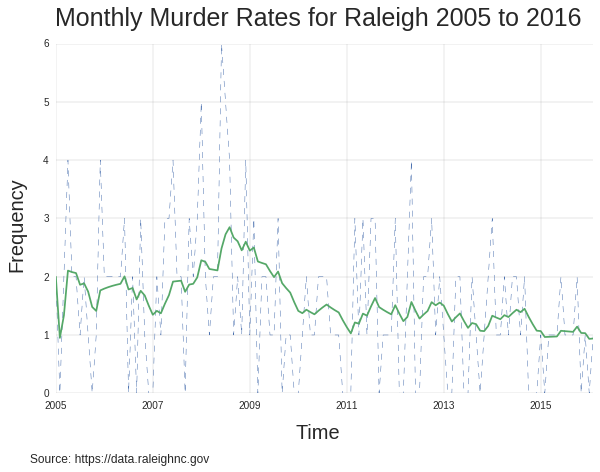

In [14]:
#Merge time series
ts_ra_murder = create_ts(df_ra_murder, "1M")

#Span is size of window
ts_ra_murder_ewma = pd.ewma(ts_ra_murder, span=20)
df_ra_murder_ts = pd.DataFrame( {'Raleigh': ts_ra_murder, 
                              'Raleigh Smooth': ts_ra_murder_ewma})

min_year = df_gta_ts.index.min().year
max_year = df_gta_ts.index.max().year

#Plot
fig, axes = plt.subplots(nrows=1, ncols=1)

fig.text(0.5, -0.04, 'Time', ha='center', fontsize=20)
fig.text(-0.04, 0.5, 'Frequency', va='center', rotation='vertical', fontsize=20)


grid_lw = 0.2
ax1 = axes
ax1.set_axis_bgcolor('white')
ax1.grid(which='major', color='grey', lw=grid_lw) 
ax1.grid(which='minor', color='white', lw=grid_lw) 

df_ra_murder_ts['Raleigh'].plot(style='--', lw=0.5, ax=ax1)
df_ra_murder_ts['Raleigh Smooth'].plot(ax=ax1)
ax1.set_xlabel('')
#ax1.set_title('Raleigh', fontsize=20)

suptitle = 'Monthly Murder Rates for Raleigh {0} to {1}'.format(min_year, max_year)
plt.suptitle(suptitle, x=0.5, y=1.05, fontsize=25)
plt.tight_layout()
plt.subplots_adjust(hspace = 0.2)

plt.figtext(0, -0.1, '''Source: https://data.raleighnc.gov''')


# Maps

In [66]:
import folium  

In [67]:
def add_marker(x, m, color):
    m.simple_marker(location = [x['Y'], x['X']], marker_color=color, )

def add_map_data(df, m, color='blue'):
    """Adds coordinate data to a folium map object"""
    df.apply(add_marker, axis=1, args=(m, color))    
    
def parse_coords(x):
    X,Y = None, None
    if x and isinstance(x, str):
        coords = x.strip("()").replace(",", "").split()
        Y, X = np.float(coords[0]), np.float(coords[1])
    return pd.Series({'X': X, 'Y': Y})

In [68]:
def add_coords(df):
    loc = df_ra['LOCATION'].fillna(value='')
    return loc.apply(parse_coords)

In [69]:
df_ra_gta[['X', 'Y']] = add_coords(df_ra_gta)
df_ra_murder[['X', 'Y']] = add_coords(df_ra_murder)

In [70]:
sf_coords = (37.76, -122.45) # = (lat, lng)
m = folium.Map(location=sf_coords, zoom_start=12)
add_map_data(df_sf_gta.sample(n=1000), m)
m

In [71]:
df_ra_gta = df_ra_gta.dropna(subset=['X', 'Y'])
df_ra_murder = df_ra_murder.dropna(subset=['X', 'Y'])

In [83]:
ra_coords = (35.83, -78.64)
m2 = folium.Map(location=ra_coords, zoom_start=11)
add_map_data(df_ra_gta.sample(1000), m2, color='blue')
m2

In [82]:
m3 = folium.Map(location=ra_coords, zoom_start=11)
add_map_data(df_ra_murder, m3, color='red')
m3

### Save Screenshots of maps

In [74]:
import os
import time
from selenium import webdriver
from IPython.display import Image

def save_map(m, html_fn, out_fn):
    #http://blog.ouseful.info/2015/12/15/grabbing-screenshots\
    #-of-folium-produced-choropleth-leaflet-maps-using-selenium/
    delay = 5
    tmpurl='file://{path}/{mapfile}'.format(path=os.getcwd(), mapfile=html_fn)
    m.save(html_fn)
    browser = webdriver.Firefox()
    browser.get(tmpurl)
    time.sleep(delay)
    browser.save_screenshot(out_fn)
    browser.quit()

In [84]:
save_map(m, 'sf_gta.html', 'sf_gta.png')
save_map(m2, 'raleigh_gta.html', 'raleigh_gta.png')
save_map(m3, 'raleigh_murder.html', 'raleigh_murder.png')